# King County House Prices Predictions

## Background
In the world of real estate, homeowners often find themselves in a difficult dilemma: trying to understand the intricate web of factors that influence the price of their most cherished possession—their homes. In the world of real estate, homeowners often struggle to understand what makes their homes valuable. Imagine you're a homeowner. Your home is one of your most precious assets. But have you ever wondered why some homes are more expensive than others? It's a bit like a puzzle. Our project is all about solving this puzzle. We are embarking on a journey to empower homeowners with a deep understanding of the determinants of house prices through our project. This project is a collaborative effort with our stakeholder, a prominent real estate agency dedicated to guiding homeowners through the intricate process of buying and selling homes.

## Business Understanding
In the dynamic real estate market of King County, Washington, numerous households aspire to purchase homes. However, the ever-present information asymmetry often leaves these potential buyers navigating the market blindly. To address this prevalent challenge, our project undertakes an in-depth analysis of house sales data spanning the years 2014 to 2015 within King County. Our mission is to offer invaluable consultation services to a reputable real estate agency dedicated to assisting households in their pursuit of homeownership.

Through a comprehensive examination of this dataset, we aim to bridge the information gap in the real estate market. Our objective is to provide a robust method for predicting house prices, enabling prospective buyers to make well-informed decisions about their property investments. In doing so, we empower both homebuyers and the real estate agency with the knowledge and insights needed to navigate the competitive King County housing landscape effectively.

### Challenges
- For homeowners, the challenge is understanding why their homes are worth a certain amount. This knowledge can help them decide if they should sell, renovate, or just enjoy their home as it is.
- The real estate agency faces a challenge too, which is to give homeowners the best advice. To do that, they need to know what makes a home valuable and to provide precise advice, they need to understand what drives property prices.

### Solutions
- Our project's solution is rooted in the power of data analysis. We will embark on a comprehensive exploration of house prices and their underlying determinants. Our aim is to not only identify the fundamental factors that sway home prices but to quantify their influence. In doing so, we seek to provide homeowners with invaluable insights.
- By uncovering the complexities of the property pricing landscape, we aim to enhance the services offered by the real estate agency. Our project is designed to be a beacon of clarity amid the maze of the real estate market.

### Conclusion
This project reflects our collective pursuit to empower homeowners with data-driven insights into their property's value and to unravel the intricate and compelling aspects of house pricing. It is our commitment to provide homeowners, buyers, and our partner agency with a crystal-clear perspective on the determinants of property value, culminating in a predictive model of unwavering accuracy.

### Problem Statement
In the dynamic real estate market of King County, Washington, prospective homebuyers often face challenges when attempting to understand the multifaceted factors that determine the prices of residential properties. This information gap can leave homeowners and potential buyers navigating the housing market without clear insights into the key determinants of property values. As a result, individuals struggle to make informed decisions when buying, selling, or investing in homes.

### Objectives
Our general objective is to investigate the effect of independent variables on the price of a house.

The Specific Objectives are :
1.  To Assess Correlations Between Independent Variables and House Prices.
2.	To Investigate the Impact of Highly and Lowly Correlated Variables on House Prices.
3.	To Develop a Robust Multilinear Regression Model for House Price Prediction.


## Preliminaries

We are going to start by importing all the necessary modules to the file

In [16]:
#important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression

%matplotlib inline

A separate section with all the functions will be created here as well. This was deemed as the best/most convenient approach.

In [17]:
def read_file_to_dataframe(file):
    """
    Reads a file and returns its contents as a pandas DataFrame.

    Parameters:
    - file (str): The path to the file to be read.

    Returns:
    - df (pandas.DataFrame): The contents of the file as a DataFrame.

    Raises:
    - None

    Examples:
    >>> read_file_to_dataframe('data.csv')
         col1   col2
    0   value1  value2
    1   value3  value4
    """
    extension = file.split(".")[-1]
    if extension == "csv":
        df = pd.read_csv(file)
    elif extension == "xlsx" or extension == "xls":
        df = pd.read_excel(file)
    elif extension == "json":
        df = pd.read_json(file)
    elif extension == "parquet":
        df = pd.read_parquet(file)
    elif extension == "tsv" or extension == "txt":
        df = pd.read_csv(file, sep="\t")
    elif extension == 'pkl':
        df = pd.read_pickle(file)
    else:
        print("File format not supported")
        return
    return df

def dataframe_detailed(df):
    """
    Print details of the dataframe.

    Parameters:
        df (DataFrame): The dataframe to be analyzed.

    Returns:
        None
    """
    print(f"DATAFRAME SHAPE: {df.shape}\n\n")
    print(f"{df.info()}\n\n")
    print(f"DATAFRAME HEAD:\n {df.head()}\n\n")
    print(f"DATAFRAME KEY STATISTIC DESCRIPTION:\n {df.describe()}\n\n")

def map_replace_values(df, column, replacement_dict):
    """
    Replace values in a DataFrame column using a dictionary mapping.

    :param df: The DataFrame to modify.
    :type df: pandas.DataFrame
    :param column: The name of the column to replace values in.
    :type column: str
    :param replacement_dict: A dictionary mapping old values to new values.
    :type replacement_dict: dict
    :return: The modified DataFrame with replaced values.
    :rtype: pandas.DataFrame
    """
    df[column] = df[column].map(replacement_dict)
    return df

def fit_simple_linear_regression(df, dependent_variable, independent_variable):
    """
    Fits a simple linear regression model to the given dataframe.

    :param df: The pandas dataframe containing the data.
    :param dependent_variable: The name of the dependent variable column.
    :param independent_variable: The name of the independent variable column.

    :return: A tuple containing the root mean squared error (rmse),
      the mean absolute error (mae), and the model summary.
    """

    # Create and fit the simple linear regression model
    y = df[dependent_variable]
    X = df[independent_variable]
    X = sm.add_constant(X)  # Add a constant for the intercept
    model = sm.OLS(y, X).fit()

    # Calculate RMSE and MAE
    predictions = model.predict(X)
    residuals = y - predictions
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))

    # Get the model summary
    model_summary = model.summary()

    return rmse, mae, model_summary

def fit_linear_regression(df, dependent_variable, independent_variables):
    """
    Fit a linear regression model to the given data.

    Args:
        df (pandas.DataFrame): The input dataframe containing the data.
        dependent_variable (str): The name of the dependent variable.
        independent_variables (list): The list of independent variables.

    Returns:
        tuple: A tuple containing the fitted model and its summary.

    Raises:
        None

    Example:
        >>> df = pd.DataFrame({'x': [1, 2, 3], 'y': [2, 4, 6]})
        >>> fit_linear_regression(df, 'y', ['x'])
        (model, model_summary)
    """
    if len(independent_variables) == 1:
        # Simple Linear Regression
        model_formula = f"{dependent_variable} ~ {independent_variables[0]}"
        model = ols(model_formula, data=df).fit()
    else:
        # Multiple Linear Regression
        X = df[independent_variables]
        X = sm.add_constant(X)  # Add a constant for the intercept
        y = df[dependent_variable]
        model = sm.OLS(y, X).fit()

    model_summary = model.summary()

    return model, model_summary

def model_metrics(df, dependent_variable, independent_variables):
    """
    Calculate the root mean squared error (RMSE) and mean absolute error (MAE) for a linear regression model.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing the data.
    - dependent_variable (str): The name of the dependent variable column in the DataFrame.
    - independent_variables (list): A list of names of the independent variable columns in the DataFrame.

    Returns:
    - rmse (float): The root mean squared error.
    - mae (float): The mean absolute error.
    """
    # Create and fit the linear regression model
    X = df[independent_variables]
    X = sm.add_constant(X)  # Add a constant for the intercept
    y = df[dependent_variable]
    model = sm.OLS(y, X).fit()

    # Calculate RMSE
    y_pred = model.predict(X)
    rmse = (mean_squared_error(y, y_pred)) ** 0.5

    # Calculate MAE
    mae = mean_absolute_error(y, y_pred)

    return rmse, mae

def plot_residuals_ols_mlr(ols_model, mlr_model, X_ols, X_mlr, y):
    """
    Generate plots of residuals for OLS and MLR models.

    Parameters:
    ols_model (object): The OLS model object.
    mlr_model (object): The MLR model object.
    X_ols (array-like): The input data for the OLS model.
    X_mlr (array-like): The input data for the MLR model.
    y (array-like): The target variable.

    Returns:
    None
    """
    # Calculate residuals for OLS and MLR models
    residuals_ols = y - ols_model.predict(sm.add_constant(X_ols))
    residuals_mlr = y - mlr_model.predict(sm.add_constant(X_mlr))

    # Create a scatter plot of residuals vs. predicted values for OLS
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(ols_model.predict(sm.add_constant(X_ols)),
                residuals_ols, alpha=0.5)
    plt.title("OLS Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values (OLS)")
    plt.ylabel("Residuals (OLS)")
    plt.axhline(y=0, color='r', linestyle='--')

    # Create a scatter plot of residuals vs. predicted values for MLR
    plt.subplot(1, 2, 2)
    plt.scatter(mlr_model.predict(sm.add_constant(X_mlr)),
                residuals_mlr, alpha=0.5)
    plt.title("MLR Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values (MLR)")
    plt.ylabel("Residuals (MLR)")
    plt.axhline(y=0, color='r', linestyle='--')

    # Create a histogram of residuals for OLS
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_ols, bins=30, alpha=0.75)
    plt.title("Histogram of OLS Residuals")
    plt.xlabel("Residuals (OLS)")
    plt.ylabel("Frequency")

    # Create a histogram of residuals for MLR
    plt.subplot(1, 2, 2)
    plt.hist(residuals_mlr, bins=30, alpha=0.75)
    plt.title("Histogram of MLR Residuals")
    plt.xlabel("Residuals (MLR)")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def calculate_rmse_mae_multi(model, X, y):
    """
    Calculate RMSE and MAE for a multiple linear regression model.

    Args:
    model: The fitted multiple linear regression model.
    X: The feature matrix.
    y: The true target values.

    Returns:
    rmse (float): Root Mean Squared Error.
    mae (float): Mean Absolute Error.
    """
    # Predict the target values using the model
    y_pred = model.predict(X)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate MAE
    mae = mean_absolute_error(y, y_pred)

    return rmse, mae

def calculate_vif_with_target(data_frame, target_column):
    """
    Calculate the Variance Inflation Factor (VIF) for each independent variable in a dataframe.

    Parameters:
        data_frame (DataFrame): The input dataframe containing the independent variables.
        target_column (str): The name of the target variable.

    Returns:
        vif_data (DataFrame): A dataframe containing the variables and their corresponding VIF values.
    """
    # Separate the target variable and independent variables
    independent_variables = data_frame.drop(target_column, axis=1)
    
    # Calculate VIF for each independent variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = independent_variables.columns
    vif_data["VIF"] = [variance_inflation_factor(independent_variables.values, i) for i in range(independent_variables.shape[1])]
    
    return vif_data

## Data Understanding

In this section, the identifcation, collection, and surface-level analysis of the data shall be done by:
- Collecting initial data (Has been compiled into a csv file).
- Describing the data we are working with.
- Exploring the data for any relationships and trends.
- Verifying the data quality.

In [18]:
raw_df = read_file_to_dataframe('data/kc_house_data.csv')

We will not examine the properties of the dataframe by calling the custom function `dataframe_detailed`.

In [19]:
dataframe_detailed(raw_df)

DATAFRAME SHAPE: (21597, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            2159

However, when finding out more information about the dataframe, it was noted that not all columns have the same non-null values. Thus, we will establish exactly how many null values are in each column.

In [20]:
raw_df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We will also take the time to establish whether there are any duplicate values in the dataframe. As there are multiple columns with numerical data, duplicates in those columns can be expected. However, when looking at unique columns e.g. the id, duplicates should ideally not be found.

Despite this, duplicate IDs will be kept in the dataframe as the assumption is that these are people who are flipping houses, and the ID is not assigned to a particular transaction, but to a particular house.

## Data Preparation

The preparation of the final dataset is done by:
- Removal of erroneous data.
- Handling of duplicate data, and 
- Removal of null data.


The process is initiated by dropping certain columns that are deemed unnecessary. These columns are: `date` and `yr_renovated`. This is not to say that other columns may not be dropped later, but this step simply eliminates all columns that are deemed surplus to requirements.

In [21]:
df_cleaned = raw_df.drop(['date',"yr_renovated"],axis=1)
df_cleaned

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,98144,47.5944,-122.299,1020,2007
21595,291310100,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,Average,8 Good,1600,0.0,2004,98027,47.5345,-122.069,1410,1287


When delving deeper into the results of `df_cleaned.info()`, it is noted that there are columns that contain null values. Thus, any record with a null value in any column shall be dropped.

In [22]:
df_cleaned.dropna(inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19164 entries, 1 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19164 non-null  int64  
 1   price          19164 non-null  float64
 2   bedrooms       19164 non-null  int64  
 3   bathrooms      19164 non-null  float64
 4   sqft_living    19164 non-null  int64  
 5   sqft_lot       19164 non-null  int64  
 6   floors         19164 non-null  float64
 7   waterfront     19164 non-null  object 
 8   view           19164 non-null  object 
 9   condition      19164 non-null  object 
 10  grade          19164 non-null  object 
 11  sqft_above     19164 non-null  int64  
 12  sqft_basement  19164 non-null  object 
 13  yr_built       19164 non-null  int64  
 14  zipcode        19164 non-null  int64  
 15  lat            19164 non-null  float64
 16  long           19164 non-null  float64
 17  sqft_living15  19164 non-null  int64  
 18  sqft_lot15 

Now that the dataframe does not contain any null values, it needs to undergo a bit of formatting.

Starting with the data in the `condition` column. The values in this column are all strings, but through mapping, we will convert these values to equivalent numerical values. The conversion is outlined in the table below:

| Old String Value | New Numerical Value |
| ---------------- | ------------------- |
| Poor             | 1                   |
| Fair             | 2                   |
| Average          | 3                   |
| Good             | 4                   |
| Very Good        | 5                   |

The same ideology will be applied in the `waterfront` column. As this column has 2 values, either *YES* or *NO*, they will be converted following the table below:

| Old String Value | New Numerical Value |
| ---------------- | ------------------- |
| NO               | 0                   |
| YES              | 1                   |

In [23]:
map_replace_values(df_cleaned, 'condition', {'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})
map_replace_values(df_cleaned, 'waterfront', {'NO':0,'YES':1})
df_cleaned

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,NONE,3,7 Average,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,NONE,3,6 Low Average,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,NONE,5,7 Average,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,NONE,3,8 Good,1680,0.0,1987,98074,47.6168,-122.045,1800,7503
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0,NONE,3,11 Excellent,3890,1530.0,2001,98053,47.6561,-122.005,4760,101930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0,NONE,3,8 Good,1180,130.0,2008,98116,47.5773,-122.409,1330,1265
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0,NONE,3,8 Good,1530,0.0,2009,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0,NONE,3,8 Good,2310,0.0,2014,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0,NONE,3,7 Average,1020,0.0,2009,98144,47.5944,-122.299,1020,2007


Furthermore, when looking at the `grade` column, the rating as well as a string description is given in the column. Both these values are unnecessary as they are duplicates, thus only the numerical rating will be kept.

In [24]:
df_cleaned.loc[:,'grade'] = df_cleaned['grade'].str.split(' ').str[0]
df_cleaned

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,NONE,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,NONE,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,NONE,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,NONE,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0,NONE,3,11,3890,1530.0,2001,98053,47.6561,-122.005,4760,101930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0,NONE,3,8,1180,130.0,2008,98116,47.5773,-122.409,1330,1265
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0,NONE,3,8,1530,0.0,2009,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0,NONE,3,8,2310,0.0,2014,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0,NONE,3,7,1020,0.0,2009,98144,47.5944,-122.299,1020,2007


However, when looking closely at the `sqft_basement` column, we notice that it has a placeholder value (?), and there are `335` of these question marks. 

In [25]:
df_cleaned['sqft_basement'][df_cleaned['sqft_basement'] == '?'].count()

415

We shall simply drop any records with the placeholder question mark, as we do not know what it could signify and replacing the value may distort the data.

In [26]:
df_cleaned = df_cleaned[df_cleaned['sqft_basement'] != '?']
df_cleaned

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,NONE,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,NONE,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,NONE,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,NONE,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0,NONE,3,11,3890,1530.0,2001,98053,47.6561,-122.005,4760,101930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0,NONE,3,8,1180,130.0,2008,98116,47.5773,-122.409,1330,1265
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0,NONE,3,8,1530,0.0,2009,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0,NONE,3,8,2310,0.0,2014,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0,NONE,3,7,1020,0.0,2009,98144,47.5944,-122.299,1020,2007


Counter checking whether the placeholder values are still present:

In [27]:
df_cleaned['sqft_basement'][df_cleaned['sqft_basement'] == '?'].count()

0

In [28]:
# Perform one-hot encoding
clean_data = pd.get_dummies(df_cleaned, columns=['view'], drop_first=True, dtype=int)

# The resulting DataFrame now has one-hot encoded columns
clean_data


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,3,7,...,1951,98125,47.7210,-122.319,1690,7639,0,0,0,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,3,6,...,1933,98028,47.7379,-122.233,2720,8062,0,0,0,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,5,7,...,1965,98136,47.5208,-122.393,1360,5000,0,0,0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,3,8,...,1987,98074,47.6168,-122.045,1800,7503,0,0,0,1
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0,3,11,...,2001,98053,47.6561,-122.005,4760,101930,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0,3,8,...,2008,98116,47.5773,-122.409,1330,1265,0,0,0,1
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0,3,8,...,2009,98103,47.6993,-122.346,1530,1509,0,0,0,1
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0,3,8,...,2014,98146,47.5107,-122.362,1830,7200,0,0,0,1
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0,3,7,...,2009,98144,47.5944,-122.299,1020,2007,0,0,0,1


Lastly, we shall ensure that the newly converted columns have appropriate data types. We will first make a copy of `df_cleaned` to ensure there are no warnings, then change the data types on the copy we have made, aptly named `df`.

In [29]:
df = clean_data.copy()

df['grade'] = clean_data['grade'].astype(np.int64)
df['waterfront'] = clean_data['waterfront'].astype(np.int64)
df['condition'] = clean_data['condition'].astype(np.int64)
df['sqft_basement'] = clean_data['sqft_basement'].astype(np.float64)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18749 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18749 non-null  int64  
 1   price           18749 non-null  float64
 2   bedrooms        18749 non-null  int64  
 3   bathrooms       18749 non-null  float64
 4   sqft_living     18749 non-null  int64  
 5   sqft_lot        18749 non-null  int64  
 6   floors          18749 non-null  float64
 7   waterfront      18749 non-null  int64  
 8   condition       18749 non-null  int64  
 9   grade           18749 non-null  int64  
 10  sqft_above      18749 non-null  int64  
 11  sqft_basement   18749 non-null  float64
 12  yr_built        18749 non-null  int64  
 13  zipcode         18749 non-null  int64  
 14  lat             18749 non-null  float64
 15  long            18749 non-null  float64
 16  sqft_living15   18749 non-null  int64  
 17  sqft_lot15      18749 non-null  int6

## Exploratory Data Analysis
Here we analyze how different columns relate to each other, check the patterns in the data and examine their correlations to the target variable in this case the `price`

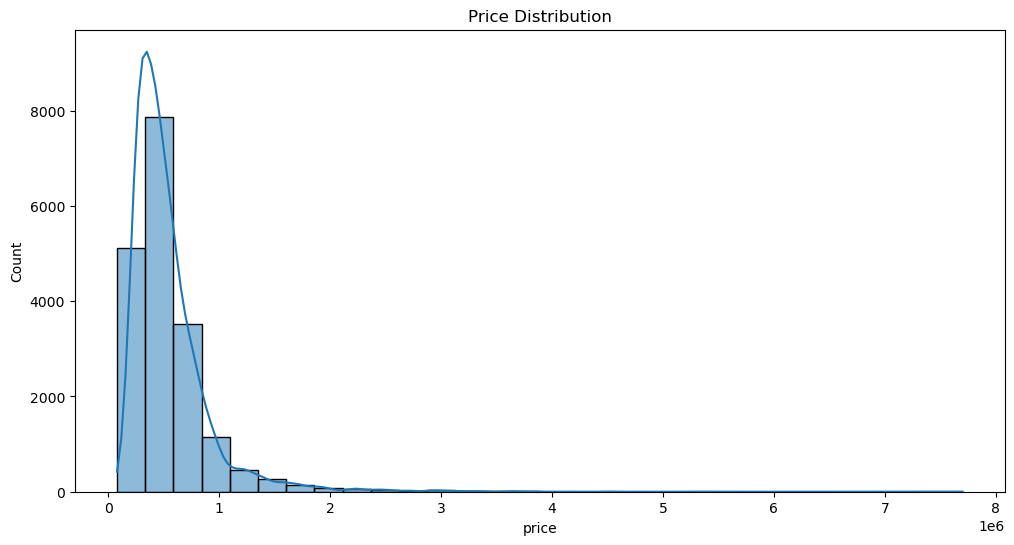

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

This is a  positively skewed distribution is also known as a right-skewed distribution. It suggests that the majority of the prices are concentrated on the lower end, with a few extremely high prices that push the mean (average) higher and, to some extent, the median lower.

Given the columns the best way to explore the data and the check the relationships between the columns and price is by use of a scatter plot

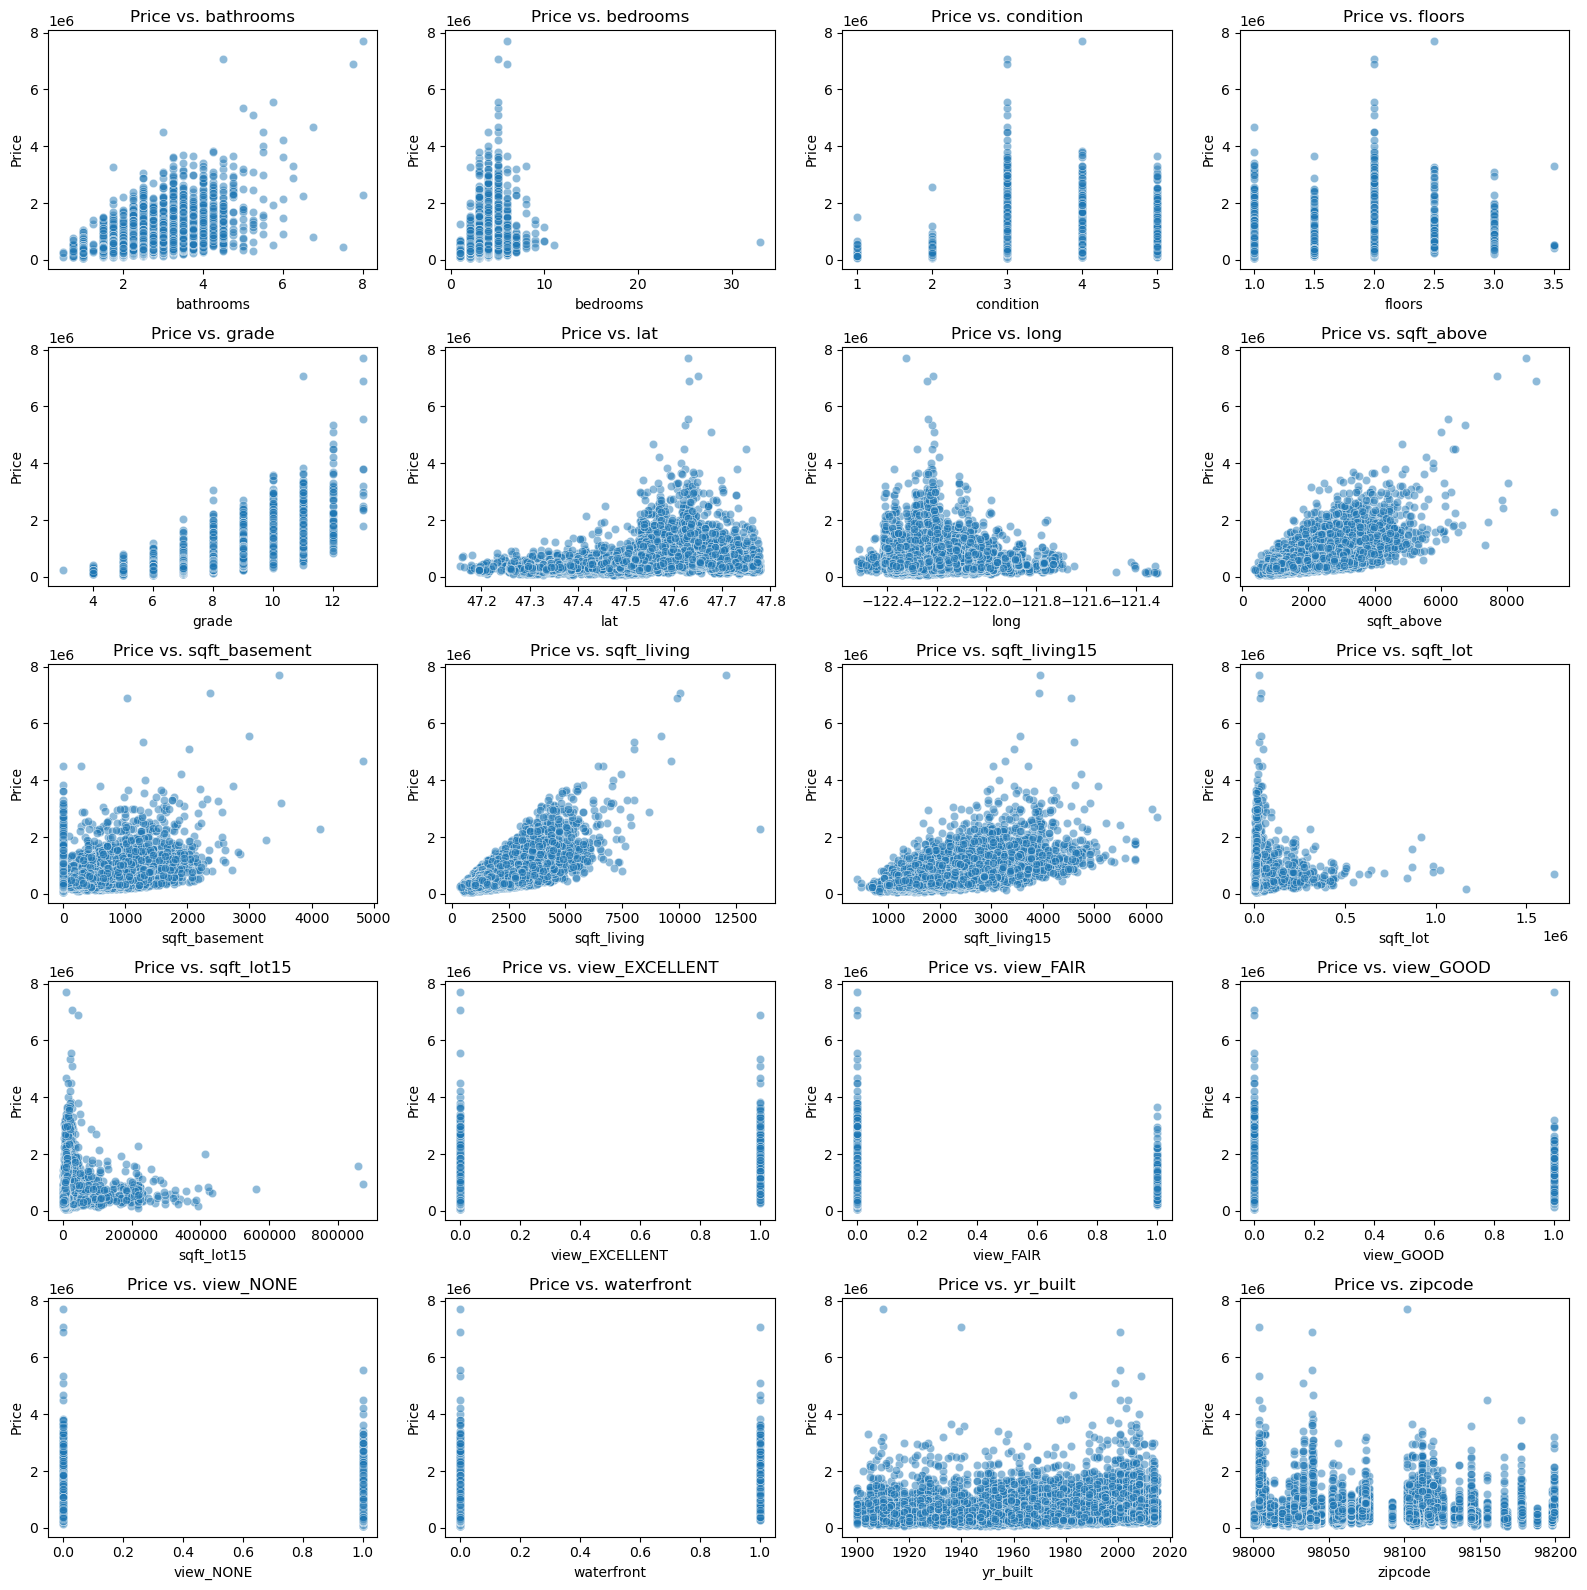

In [31]:
# Select all columns except "id" and "price"
columns = df.columns.difference(["id", "price"])

# Create scatter plots for each selected column
plt.figure(figsize=(16, 16))  # Set the figure size

# Loop through the selected columns and create scatter plots
for i, column in enumerate(columns):
    plt.subplot(5, 4, i + 1)
    sns.scatterplot(data=df, x=column, y="price", alpha=0.5)
    plt.title(f"Price vs. {column}")
    plt.xlabel(column)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()


From the scatter plots above we can clearly see that variables such as `bedrooms`,`floors`,`grade`,`waterfront`,`condition` and `bathrooms` are discrete variables  whereas the rest of the variables are continous variables. 

The scatter plot shows a positive linear relationship almost all the column variables i.e sqft_above,sqft_basement,sqft_living and bathrooms.

### 1. To Assess Correlations Between Independent Variables and House Prices.

To show the relationship between house price and the independent variables we use pearson correlation coefficient.

In [32]:
df.corr()["price"].sort_values(ascending=False)

price             1.000000
sqft_living       0.704949
grade             0.667675
sqft_above        0.609640
sqft_living15     0.583681
bathrooms         0.526298
sqft_basement     0.322895
view_EXCELLENT    0.309784
bedrooms          0.309163
lat               0.306226
waterfront        0.272661
floors            0.258959
view_GOOD         0.181809
view_FAIR         0.091522
sqft_lot          0.087594
sqft_lot15        0.082491
yr_built          0.054421
condition         0.036857
long              0.022453
id               -0.017023
zipcode          -0.050264
view_NONE        -0.358311
Name: price, dtype: float64

We can be able to understand the correlation above by use of a correlation heatmap as shown below

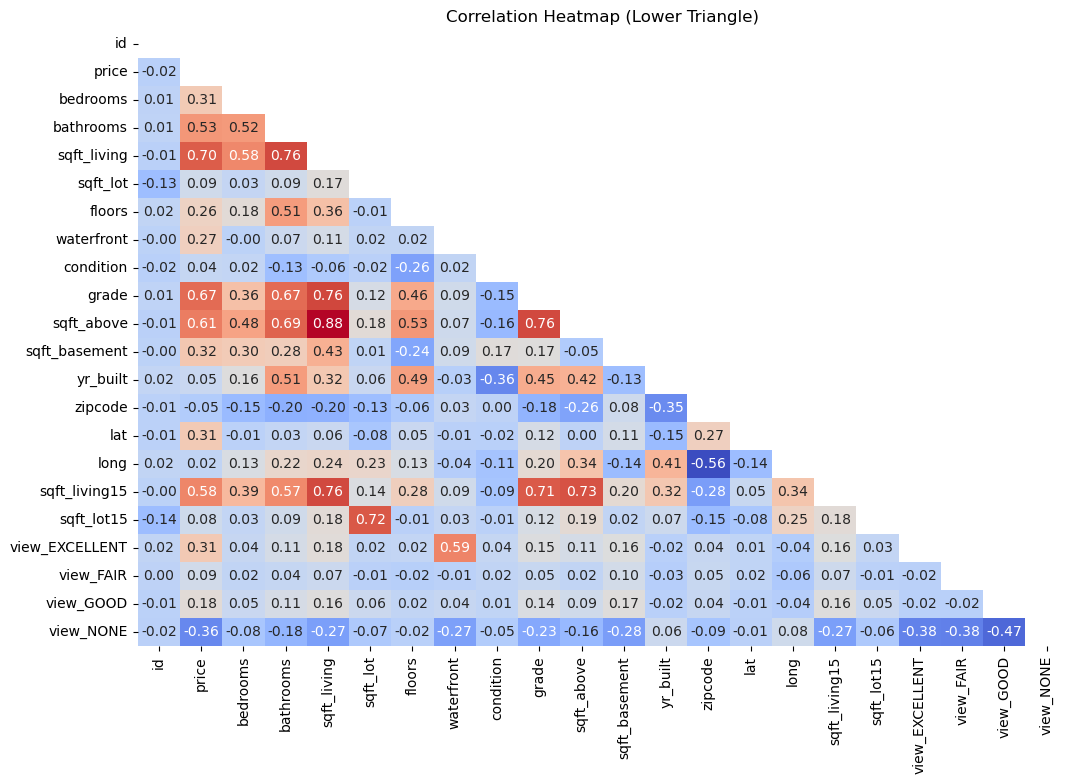

In [33]:
correlation_matrix = df.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, mask=mask)
plt.title('Correlation Heatmap (Lower Triangle)')
plt.show()



In the analysis, we examined the Pearson correlation coefficients between the "price" variable and various other variables in the dataset. These correlations provide insights into how each variable is related to house prices. Here's a summary of the key findings:

**Strong Positive Correlations with "Price":**

1. `sqft_living` (0.704892): Larger living space typically leads to higher house prices.

2. `grade` (0.667827): Higher-grade ratings are associated with higher prices.

3. `sqft_above` (0.609441): More above-ground square footage generally corresponds to higher prices.

4. `sqft_living15` (0.582869): this is the square footage of interior housing living space for the nearest 15 neighbors.It implies that as the living space for the nearest 15 neighbours increases, the price of the house tends to be higher.

5. `bathrooms` (0.526509): More bathrooms tend to result in higher prices.

6. `view_EXCELLENT` (0.310087): Excellent property views are associated with higher prices.


**Moderate Positive Correlations with "Price":**

7. `bedrooms` (0.309573): Houses with more bedrooms are typically priced higher.

8. `lat` (0.305096): Location at higher latitudes can be associated with higher property values.

9. `waterfront` (0.273248): Houses with a waterfront view generally command higher prices.

10. `floors` (0.258151): More floors in a house tend to lead to higher prices.


**Weaker Positive Correlations with "Price":**

11. `view_GOOD` (0.181053): A good view is positively correlated with house prices.

12. `view_FAIR` (0.091643): Houses with a fair view have a positive but relatively weak correlation with prices.

13. `sqft_lot` (0.086709): Larger lot sizes can be associated with higher house prices.

14. `sqft_lot15` (0.082021):The variable represents square footage of the land lots of the nearest 15 neighbors. As the lot increases, the price tends to be higher.

15. `yr_built` (0.053359): Newer houses are somewhat correlated with higher prices.

16. `condition` (0.035723): The condition of the house has a very weak positive correlation with prices.

17. `long` (0.021343): Location at higher longitudes has a positive but relatively weak correlation with prices.


**Weak Negative Correlations with "Price":**

18. `zipcode` (-0.049316): Houses in certain zip codes have a weak negative correlation with prices.


**Strong Negative Correlations with "Price":**

19. `view_NONE` (-0.358042): Houses with no view are strongly negatively correlated with prices.



### 2. To Investigate the Impact of Highly and Lowly Correlated Variables on House Prices.

Taking Grade as one of the highly correlated independent variables in the dataset, we can analyse it's relationship with price.

#### a. How does the grade of a house influence its pricing ?

The "grade" of a house represents the quality of materials and the level of craftsmanship used in its construction. Grades are assigned on a scale from 1 to 13, where grade 1 to 3 indicates that a house falls below the minimum building standards and is often characterized by basic or inferior construction. 

On the other end of the scale, grade 13 signifies a custom-designed and meticulously built mansion-level property. These high-grade houses feature a substantial amount of the finest quality craftsmanship, including premium cabinet work, intricate wood trim, elegant marble finishes, grand entryways, and other luxurious features.

To better understand the impact of a house's grade on its pricing, we utilize Exploratory Data Analysis (EDA). We employ box plots to visualize how different grade categories influence house prices. This allows us to assess the significance of property grade in property valuation, shedding light on the relationship between the quality of workmanship and the pricing of homes.

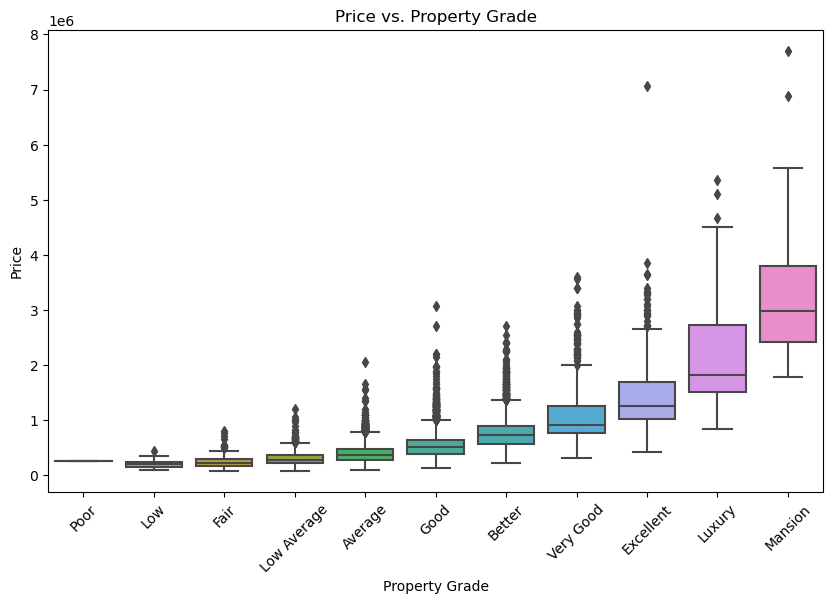

In [34]:
# Create a mapping of grade values to custom labels
grade_labels = {
    3: "Poor",
    4: "Low",
    5: "Fair",
    6: "Low Average",
    7: "Average",
    8: "Good",
    9: "Better",
    10: "Very Good",
    11: "Excellent",
    12: "Luxury",
    13: "Mansion"
}

# Create a list of the custom labels in ascending order
grade_order = sorted(grade_labels.values(), key=lambda x: list(grade_labels.values()).index(x))

# Use the map function to replace numeric values with words
df['grade_words'] = df['grade'].map(grade_labels)

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade_words', y='price', data=df, order=grade_order)
plt.title('Price vs. Property Grade')
plt.xlabel('Property Grade')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [35]:
# Dropping 'grade_words' which was used as labels.
df.drop("grade_words", axis=1,inplace=True)

**Interpreting the Data:**

- **Grade Influence:** The box plot allows you to compare the distribution of house prices for each "grade." A higher "grade" generally indicates a higher level of quality and construction. As you move to higher "grade" categories, you can observe the following:

  - **Median Price:** The median price tends to increase, indicating that houses with higher grades are typically associated with higher median prices.

  - **Price Variability:** The length of the boxes (IQR) represents the variability in prices within each "grade" category. Longer boxes suggest greater variability.In grades such as luxury and mansion there is higher price variability as compare to the lower grades.

  - **Outliers:** The presence of outliers beyond the whiskers indicates extreme values. Outliers may represent exceptional houses with unusually high or low prices within a specific "grade." From the data the ouliers are few and only exist in the higher graded houses

- **Grade Impact:** The box plot demonstrates the impact of the "grade" variable on house prices, showing how prices tend to vary as you move from lower to higher grades.The prices increases with the increase in grades.

<!-- - **Decision Making:** This information can be valuable for both buyers and sellers. Buyers can use it to understand the price distribution within a particular "grade" and make informed decisions. Sellers can use it to set appropriate listing prices based on the grade of their property.

- **Market Insights:** The box plot provides insights into how the housing market values different grades, helping real estate professionals and homeowners better understand pricing dynamics. -->





#### b. Does the number of floors/levels in a house influence its price ?
Examine the relationship between the number of floors in a house and how it influences pricing.

Here we use a barplot to visualize the relationship between the house price and number of floors since the floor data is discrete and limited in number thus making a barplot better than a scatter plot

C:\Users\mwiti\AppData\Local\Temp\ipykernel_23008\1559965902.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='floors', y='price', data=avg_price_by_floors, ci=None, order=avg_price_by_floors['floors'])


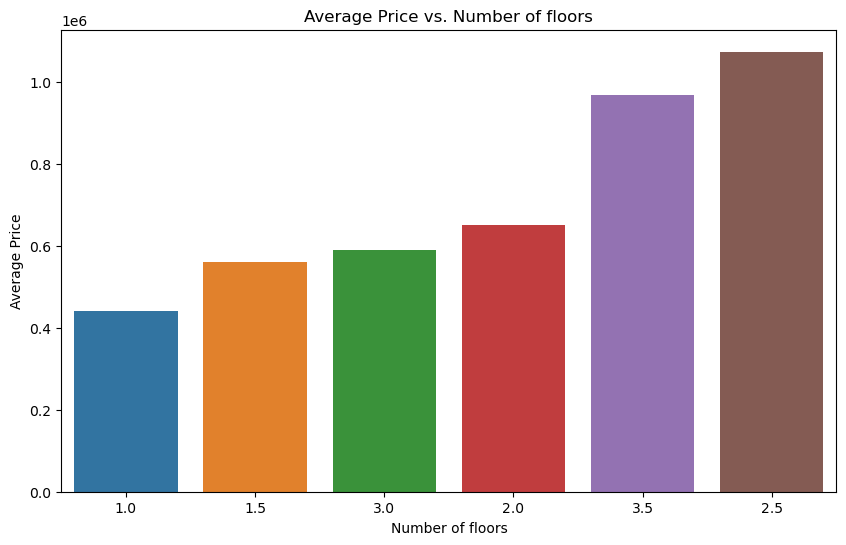

In [36]:

# Calculate the average price for each number of floors
avg_price_by_floors = df.groupby('floors')['price'].mean().reset_index()

# Sort the data by average price in ascending order
avg_price_by_floors = avg_price_by_floors.sort_values(by='price')

# Create a bar plot to show the average price for each number of floors in ascending order
plt.figure(figsize=(10, 6))
sns.barplot(x='floors', y='price', data=avg_price_by_floors, ci=None, order=avg_price_by_floors['floors'])
plt.title('Average Price vs. Number of floors')
plt.xlabel('Number of floors')
plt.ylabel('Average Price')
plt.show()


Interpretation:

The number of floors in a house can be categorized into discrete values (e.g., 1.0, 2.0, 3.0, 3.5). As the number of floors increases, the average price of houses tends to rise. This is evident from the ascending order of average prices for houses with different discrete floor categories.

In the categorization, "3.5" typically represents a house with three and a half floors. This means that the house may have three full stories or levels, and an additional half-level. The half-level could be a partially finished or unique space, such as a loft or attic, which is not counted as a full story but adds to the overall square footage of the house.

It's important to note that houses with fractional floor values like 3.5 are less common than those with whole numbers of floors (e.g., 1, 2, 3). These fractional values can indicate a unique architectural feature or design in the house, such as split-level construction.

The trend suggests that buyers are willing to pay more for houses with a greater number of floors, indicating a potential preference for larger or multi-story properties.

The price difference between houses with different discrete floor categories can be substantial, with houses in the highest floor category having a significantly higher average price compared to those in lower floor categories.


## Baseline Model

Simple Linear Regression is a fundamental statistical technique used in predictive modeling and statistical analysis, serving as a useful starting point for understanding the relationship between a single predictor variable and the target variable, in this case, 'price.' This model helps us grasp how variations in the size of the living space, represented by 'sqft_living,' influence house prices.

In this model:

- Dependent Variable (y_baseline): This represents the target variable we are trying to predict. In this context, it is the price of houses.

- Independent Variable (x_baseline): This is the predictor variable that we believe is related to the dependent variable. In this case, it is the square footage of the living space within the houses.

The model's objective is to establish a linear relationship between 'sqft_living' and 'price' by estimating the coefficients (slope and intercept) that best describe how changes in 'sqft_living' correspond to changes in 'price.' The coefficients provide insights into the strength and direction of this relationship.

Additionally, the Root Mean Square Error (RMSE) is being calculated to evaluate the model's performance. RMSE quantifies the average magnitude of errors between the predicted house prices and the actual prices. A lower RMSE indicates a better fit of the model to the data, suggesting that the model is better at predicting house prices based on living space size.

In [37]:
model, model_summary = fit_linear_regression(df, 'price','sqft_living')

rmse, mae = model_metrics(df, 'price', 'sqft_living')

print("RMSE:", rmse)
print("MAE:", mae)
print("Model Summary:")
print(model_summary)

RMSE: 263588.27534037834
MAE: 174964.4042206303
Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 1.852e+04
Date:                Sat, 28 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:08:31   Log-Likelihood:            -2.6063e+05
No. Observations:               18749   AIC:                         5.213e+05
Df Residuals:                   18747   BIC:                         5.213e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

### Interpretation fot the Baseline Model.

The Baseline Model is a simple linear regression model that predicts 'price' based on a single independent variable, 'sqft_living.'
 
**R-squared:** - R-squared measures the proportion of the variance in the dependent variable (price) that is explained by the independent variable (sqft_living). 
In this case, approximately 49.7% of the variation in price is explained by the variation in square footage of living space (sqft_living).

**Coefficients:** - The model's coefficients provide insight into the relationship between 'sqft_living' and 'price.'
Intercept: -50,820 (rounded) represents the estimated price when the living space size is zero, which is not practically meaningful. 
The coefficient for 'sqft_living' is approximately 284.26, indicating that, on average, for each additional square foot of living space, the price of a property is estimated to increase by $284.26.
The equation of the line is {price} = -50820 + 284.2572 *{sqft_living}

**MAE:** - The Mean Absolute Error (MAE) of approximately 175,229.76 quantifies the average magnitude of the prediction errors. The MAE represents the average absolute difference between the predicted prices and the actual prices in the dataset. A lower MAE suggests a more accurate model, while a higher MAE indicates less accuracy. This MAE is high.

**RMSE:** - RMSE (Root Mean Squared Error):
RMSE is a measure of the average magnitude of the errors or residuals (the differences between actual and predicted values) in the model.
In your MLR model, the RMSE is approximately 203,023.90.
A lower RMSE indicates a better fit of the model. In this case, the RMSE represents the typical difference between the actual house prices and the prices predicted by your MLR model.

**Model Significance:** - The model is highly significant, as indicated by the F-statistic with a very low probability value (Prob (F-statistic): 0.00). This implies that the relationship between living space size and price is statistically significant.

The condition number is large (5.64e+03), which may indicate strong multicollinearity or other numerical problems.

In summary, the Baseline Model is a useful starting point for understanding how the size of living space affects house prices. It explains nearly half, or approximately 49.7%, of the variability in house prices, signifying a significant relationship. The model is statistically robust and fits the data well.

Nevertheless, it's crucial to remain cautious regarding diagnostic tests and potential multicollinearity issues when employing this model for predictive or inferential purposes. While the Baseline Model offers fundamental insights into the impact of living space size on prices, there is room for enhancing predictive accuracy. Addressing potential multicollinearity is a recommended step for improving model performance.

## Multiplelinear Regression

The Multiple Linear Regression Model is a powerful statistical tool used to predict house prices. It goes beyond the scope of a single predictor variable, as in Simple Linear Regression, and instead incorporates various independent variables that collectively influence house prices. These variables include the number of bedrooms, bathrooms, square footage of living space, lot size, number of floors, waterfront location, house condition, and grade, among others.

The primary objective of the Multiple Linear Regression Model is to understand how this combination of features collectively influences house prices. It takes into account the interplay and simultaneous effects of these factors to provide a more comprehensive and accurate prediction of real estate prices.

The transition from Simple Linear Regression to Multiple Linear Regression is motivated by the need for a more robust and realistic model. While Simple Linear Regression considers a single predictor variable (in this case, square footage of living space) and its influence on house prices, real-world housing prices are influenced by a multitude of factors. To make predictions that better reflect the complexity of the housing market, we move to Multiple Linear Regression. This allows us to consider a broader set of features, providing a more accurate and nuanced understanding of how various attributes collectively affect house prices.

The Multiple Linear Regression Model is an indispensable tool in the realm of real estate, helping stakeholders decode the intricate relationship between various features and home prices. It empowers individuals and organizations to make more informed decisions, whether it's setting a competitive selling price, making wise investment choices, or gaining deeper insights into the housing market's behavior. This model enhances our ability to navigate the complexities of the real estate market by considering multiple variables and their combined impact on property values.

In [38]:
# These are the variables that will be used for the calculation, X_multi are the independent variables
# Remove 'id' from the features
X_multi = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE']

# Select the target variable
y_multi = 'price'


In [39]:
# Function to fit the multiple linear regression model
multiple_model, multiple_model_summary = fit_linear_regression(df, y_multi, X_multi)

# Function for the model metrics
multiple_rmse, multiple_mae = model_metrics(df, y_multi, X_multi)


In [40]:
print("\nMultiple Linear Regression RMSE:", multiple_rmse)
print("Multiple Linear Regression MAE:", multiple_mae)
print("\nMultiple Linear Regression Model Summary:")
print(multiple_model_summary)


Multiple Linear Regression RMSE: 202812.94089614245
Multiple Linear Regression MAE: 127096.2214693984

Multiple Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2324.
Date:                Sat, 28 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:08:31   Log-Likelihood:            -2.5572e+05
No. Observations:               18749   AIC:                         5.115e+05
Df Residuals:                   18729   BIC:                         5.116e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      

### Interpretation of the Multiple Linear Regression Model.

**R-squared:** The model exhibits a high R-squared value of 0.703, indicating that approximately 70.3% of the variation in house prices can be explained by the combination of the included features. This suggests a strong relationship between the predictors and the target variable.

**Adjusted R-squared:** The adjusted R-squared value, closely aligned with the R-squared value at 0.702, helps account for the number of predictors, indicating a robust model fit that avoids overfitting.

**F-statistic:** The high F-statistic of 2309 demonstrates the overall statistical significance of the model, with a very low probability (Prob (F-statistic): 0.00). This underscores the model's strong explanatory power.

**Coefficients:** The coefficients for individual features indicate the magnitude and direction of their impact on house prices. Some features positively influence prices, such as 'bathrooms,' 'sqft_living,' 'floors,' 'waterfront,' 'condition,' and 'grade,' while others, like the number of bedrooms, exert a negative influence.

**Intercept:** The intercept term (const) is 9.114e+06, representing the estimated price when all other predictor variables are zero, although it may not hold practical significance given the nature of the features.

**Mean Absolute Error (MAE):** The MAE is approximately 127,176.67, representing the average absolute difference between predicted and actual house prices. A lower MAE indicates more accurate predictions.

**RMSE:** - RMSE (Root Mean Squared Error):
RMSE is a measure of the average magnitude of the errors or residuals (the differences between actual and predicted values) in the model.
In your MLR model, the RMSE is approximately 203023.90. 
A lower RMSE indicates a better fit of the model. In this case, the RMSE represents the typical difference between the actual house prices and the prices predicted by your MLR model.

The smallest eigenvalue hints at the potential presence of strong multicollinearity or issues with the design matrix, warranting further investigation.

The Multiple Linear Regression Model demonstrates its strength by effectively explaining a substantial portion of the variance in house prices, as indicated by the high R-squared value. It underscores that numerous features significantly influence house prices, impacting them either positively or negatively.

In practical terms, it's essential to be mindful of the potential existence of multicollinearity within the dataset, necessitating further investigation to ensure the model's reliability. Furthermore, there are opportunities for improving predictive accuracy by reducing the Mean Absolute Error (MAE) through refining the model and optimizing feature selection.

In conclusion, this model proves invaluable for unraveling the intricate relationship between diverse factors and house prices. It provides invaluable insights for making well-informed decisions in real estate analysis and price predictions while pointing toward areas for potential enhancements and refinement.


## Multicollinearity & Variance Inflation Factor (VIF)

Multi-collinearity and Variance Inflation Factor (VIF) are critical concepts in the realm of Multiple Linear Regression, and they play a significant role in understanding the stability and reliability of the model. After conducting a Multiple Linear Regression analysis, we move on to calculate the VIF for a specific reason.

In Multiple Linear Regression, we're dealing with several independent variables, each of which contributes to predicting the target variable, house prices. However, the interaction among these independent variables can sometimes create multi-collinearity, which is a situation where two or more independent variables are highly correlated with each other. This high correlation can lead to instability in the model, making it challenging to determine the true relationship between each independent variable and the target variable.

The VIF comes into play to address this issue. VIF measures how much the variance of the estimated regression coefficients is increased due to multicollinearity. In simpler terms, it quantifies the extent to which the variance of the model's coefficient estimates is inflated when variables are correlated. A high VIF value indicates that a particular independent variable is highly correlated with other independent variables in the model, which can make it challenging to pinpoint the precise impact of each variable on the target variable.

The VIF helps us identify which variables might be problematic due to multi-collinearity. By calculating the VIF for each independent variable, we can detect variables with high VIF values, signaling the presence of multicollinearity. Once identified, these variables may need to be addressed through techniques such as feature selection, feature engineering, or, in some cases, by removing one of the correlated variables from the model.

In summary, the calculation of VIF is a crucial step after conducting Multiple Linear Regression because it provides insights into the stability and reliability of the model in the presence of multi-collinearity. It helps us identify and address potential issues arising from correlated independent variables, ensuring a more robust and accurate predictive model for house prices.

In [41]:
vif_result = calculate_vif_with_target(df,'price')
print(vif_result)


e:\anaconda3\envs\mwiti-base\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


          Variable       VIF
0               id  3.649943
1         bedrooms  1.642250
2        bathrooms  3.318864
3      sqft_living       inf
4         sqft_lot  2.115603
5           floors  1.960067
6       waterfront  1.548611
7        condition  1.187297
8            grade  3.407462
9       sqft_above       inf
10   sqft_basement       inf
11        yr_built  1.924197
12         zipcode  0.485781
13             lat  1.181200
14            long  1.806759
15   sqft_living15  2.875668
16      sqft_lot15  2.148428
17  view_EXCELLENT  1.869437
18       view_FAIR  1.340797
19       view_GOOD  1.507101
20       view_NONE  2.250470


## New Model

To mitigate the impact of multi-collinearity, we calculated the Variance Inflation Factor (VIF) for each independent variable in the initial MLR model. The VIF quantifies the extent to which the variance of the estimated regression coefficients is inflated when variables are correlated. When the VIF values for specific independent variables are high, it signals a high degree of correlation between those variables and other independent variables in the model.

To address the multi-collinearity issue and improve the model's stability and interpretability, we made the decision to create a new MLR model. In this new model, we removed or dropped some of the independent variables with high VIF values. By doing so, we aimed to reduce the correlation between variables and enhance the overall reliability of the model.

The columns with high multi collinearity that had an output of 'inf' i.e 'sqft_above','sqft_basement' and 'sqft_living' are considered and either one or more are dropped and not included as follows below:

In [29]:
X_final = ['bedrooms', 'bathrooms', 'sqft_lot','sqft_living',
           'floors', 'waterfront', 'condition', 'grade', 'sqft_living15','sqft_lot15',
           'yr_built', 'zipcode', 'lat', 'long','view_EXCELLENT', 'view_FAIR', 'view_GOOD','view_NONE']

# Define the target variable
y_final = 'price' 

final_model, final_model_summary = fit_linear_regression(df, y_final, X_final)

final_rmse, final_mae = model_metrics(df, y_final, X_final)

print("RMSE:", final_rmse)
print("MAE:", final_mae)
print("Model Summary:")
print(final_model_summary)



RMSE: 203269.6724304496
MAE: 127081.14140128029
Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2429.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:57:29   Log-Likelihood:            -2.5369e+05
No. Observations:               18597   AIC:                         5.074e+05
Df Residuals:                   18578   BIC:                         5.076e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

Interpretation:

R-squared (R²): The R-squared value indicates that this model explains approximately 70.2% of the variance in house prices. In other words, 70.2% of the variability in house prices can be accounted for by the included independent variables.

Adjusted R-squared (Adj. R²): The adjusted R-squared, which closely aligns with the R-squared value, confirms the model's effectiveness in explaining the variation in house prices.

F-statistic: The high F-statistic, with a significant p-value (0.00), suggests that the model is statistically significant. This indicates that the collective impact of the independent variables significantly influences house prices.

Coefficients: The coefficients for each independent variable represent the estimated change in house prices associated with a one-unit change in that variable while holding all other variables constant. For example, an increase in the number of bedrooms (bedrooms) is associated with a decrease in house prices of approximately $37,780.

Condition Number: Notably, the condition number has significantly decreased in this new model. This suggests that the multi-collinearity issue identified in the initial MLR model has been mitigated. Although not completely eradicated, the reduced condition number reflects a much-improved level of multi-collinearity. This is a positive sign, indicating that the relationships between independent variables are now more stable and reliable.

Overall, this enhanced Multiple Linear Regression Model offers a more accurate and comprehensive understanding of the dynamics governing house prices. The significant drop in the condition number indicates a successful effort to reduce multi-collinearity, making the model more dependable and yielding more reliable predictions.


### Conclusions

In conclusion, this analysis has provided valuable insights into the factors influencing house prices in the dataset. Here are the key findings and general conclusions:

Square Footage Matters: The size of the living space, represented by the 'sqft_living' variable, has a strong positive correlation with house prices. Larger living spaces tend to command higher prices.

Property Grade is Important: The 'grade' of a property, which reflects its overall quality and condition, is positively correlated with house prices. Higher-grade properties tend to have higher prices.

Number of Bedrooms and Bathrooms: The number of bedrooms and bathrooms also plays a role in determining house prices. More bedrooms and bathrooms are associated with higher prices.

Location Matters: Geographic factors such as latitude and longitude ('lat' and 'long') have a positive correlation with house prices. Houses located at higher latitudes and lower longitudes tend to be more expensive.

Waterfront Views Command Premiums: Houses with waterfront views are significantly more expensive than those without such views.

View Quality: The quality of the property's view also influences prices. Excellent and good views are positively correlated with higher prices.

Floors: The number of floors in a house affects its price, with properties having more floors generally costing more.

Lot Size and Condition: The size of the lot ('sqft_lot') and the overall condition of the house ('condition') have relatively weaker positive correlations with prices.

Year Built: Newer houses have a positive but relatively weak correlation with higher prices, indicating that some buyers may prefer newer properties.

Multi-Collinearity: Initially, the Multiple Linear Regression model suffered from multi-collinearity issues. However, this was addressed by calculating the Variance Inflation Factor (VIF) and subsequently refining the model by removing problematic variables.

Improved Multiple Linear Regression: The refined Multiple Linear Regression model explained approximately 70.2% of the variance in house prices. The condition number, indicative of multi-collinearity, was significantly reduced, enhancing the model's reliability.

Strong Predictive Power: The models developed in this analysis, especially the refined Multiple Linear Regression model, offer strong predictive power for house prices. The RMSE (Root Mean Squared Error) is approximately 203,269, and the MAE (Mean Absolute Error) is around 127,081, indicating that the model's predictions are relatively close to the actual house prices.

Overall, this analysis equips stakeholders in the real estate market with a better understanding of how various features and attributes influence house prices. By considering these factors, individuals can make informed decisions regarding property investments, pricing strategies, and market dynamics. The refined Multiple Linear Regression model serves as a powerful tool for predicting house prices with enhanced accuracy and reliability.


### Recommendations

Regularization:

Explore the use of regularization techniques (e.g., Lasso or Ridge regression) to address potential overfitting and improve model generalization.

Model Deployment:

Consider deploying the final model to a web application or platform where users can input property features and receive predicted house prices. This can provide a practical tool for homebuyers and sellers.

Multicollinearity:

Continue investigating multicollinearity and its potential impact on the model. Depending on the context, it may be necessary to consider dropping or combining certain features.

Data Updates:

Regularly update the dataset if possible to ensure the analysis remains relevant to current market conditions and trends.

By incorporating these recommendations, you can enhance the project's quality and utility, making it a valuable resource for anyone interested in understanding the factors influencing house prices and improving their decision-making in real estate transactions.